In [ ]:
!pip install autoray==0.2.5
!apt-get update && apt-get install python-opengl xvfb
!pip install pyvirtualdisplay wandb==0.13.10 pennylane gym[classic_control]

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [783 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2,104 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ub

In [ ]:
from collections import namedtuple,deque
import random
import numpy as np
import pandas as pd
import torch
class ER_Memory(object):
    def __init__(self, state_size, action_size, capacity):
        self.capacity = capacity
        self.state_size = state_size
        self.action_size = action_size
        self.data = {
            'states': np.zeros((capacity, self.state_size), dtype=np.float64),
            'actions': np.zeros((capacity,self.action_size ), dtype=int),
            'rewards': np.zeros((capacity,1), dtype=int),
            'next_states': np.zeros((capacity, self.state_size), dtype=np.float64),
            'dones': np.zeros((capacity), dtype=np.int64)
        }
        self.index = 0
        self.size = 0

    def remember(self, *args):
        exp = [*args]

        self.data["states"][self.index] = np.eye(self.state_size)[exp[0]] if type(exp[0]) == int or type(exp[0]) == float  else exp[0]
        self.data["actions"][self.index] = int(exp[1])
        self.data["rewards"][self.index] = exp[2]
        self.data["next_states"][self.index] = np.eye(self.state_size)[exp[3]] if type(exp[3]) == int or type(exp[3]) == float else exp[3]
        self.data["dones"][self.index] = exp[4]

        self.index = (self.index+1)%self.capacity
        self.size = min(self.size+1, self.capacity)

    def sample(self, batch_size):
        batch_size = min (self.size, batch_size)
        batch_idxs = np.random.choice(np.arange(self.size), size=batch_size, replace=False)
        samples = {}
        for k, v in self.data.items():
          samples[k] = v[batch_idxs]
        return samples

    def __len__(self):
      return self.size

    def save(self, path):
      d = self.data
      np.save(d,path)

    def load(self,path):
      self.data = np.load(path)
      self.index = self.data["index"]

    def show(self):
      df =  pd.DataFrame()
      df["states"]= list(self.data["states"])
      print(self.data["actions"])
      df["actions"]= self.data["actions"]
      df["rewards"]= self.data["rewards"]
      df["next_states"] = list(self.data["next_states"])
      df["dones"] = self.data["dones"]
      return df

In [ ]:
from scipy.stats import rankdata
class PER_Memory(object):  # stored as ( state, action, reward, next_state ) in SumTree
    # Taken from https://nn.labml.ai/rl/dqn/replay_buffer.html
    def __init__(self, state_size, action_size, capacity, per_alpha=.6, per_beta=.4,per_beta_per=0.0005, per_e=1e-5, is_ranking=False):
        # Making the tree
        self.capacity = capacity
        self.device = device
        self.is_ranking = is_ranking
        self.state_size = state_size
        self.action_size = action_size
        self.data = {
            'states': np.zeros((capacity, self.state_size), dtype=np.float64),
            'actions': np.zeros((capacity,self.action_size ), dtype=int),
            'rewards': np.zeros((capacity,1), dtype=int),
            'next_states': np.zeros((capacity, self.state_size), dtype=np.float64),
            'dones': np.zeros((capacity), dtype=np.int64)
        }
        self.priorities = np.zeros(capacity)
        self.index = 0
        self.size = 0
        self.e = per_e  # Hyperparameter that we use to avoid some experiences to have 0 probability of being taken
        self.alpha = per_alpha  # Hyperparameter that we use to make a tradeoff between taking only exp with high priority and sampling randomly
        self.beta = per_beta  # importance-sampling, from initial value increasing to 1
        self.beta_increment = per_beta_per
        self.absolute_error_upper = 10  # clipped abs error
        self.max_priority = 1


    def remember(self, *args):
        exp = [*args]
        self.data["states"][self.index] = np.eye(self.state_size)[exp[0]] if type(exp[0]) == int or type(exp[0]) == float  else exp[0]
        self.data["actions"][self.index] = int(exp[1])
        self.data["rewards"][self.index] = exp[2]
        self.data["next_states"][self.index] = np.eye(self.state_size)[exp[3]] if type(exp[3]) == int or type(exp[3]) == float else exp[3]
        self.data["dones"][self.index] = exp[4]
        max_priority = np.max(self.priorities) if self.size > 0 else self.max_priority
        self.size = min(self.size+1, self.capacity)
        self.priorities[self.index] = max_priority
        self.index = (self.index+1)%self.capacity

    def sample(self, batch_size):
        # Create a minibatch array that will contains the minibatch
        if self.is_ranking:
          priorities = 1/(rankdata(self.priorities[:self.size]).astype(int))
        else:
          priorities = self.priorities[:self.size]
        probs = (priorities ** self.alpha) / np.sum(priorities ** self.alpha)
        indices = np.random.choice(self.size, batch_size, p=probs,replace=False)
        weights = (self.size * probs) ** (-self.beta)

        weights /= weights.max()

        samples = {"indexes": indices}
        samples["weights"] = weights[indices]
        for k,v in self.data.items():
          samples[k] = v[samples["indexes"]]
        samples["beta"] = self.beta
        return samples

    def update_beta(self):
        self.beta = min(1., self.beta + self.beta_increment)
        return self.beta

    def update_priorities(self, indices, td_errors):
        for idx, td_error in zip(indices, td_errors):
            self.priorities[idx] = td_error+self.e
    def __len__(self):
        return self.size

    def show(self):
        df =  pd.DataFrame()
        df["states"]= list(self.data["states"])
        df["actions"]= self.data["actions"]
        df["rewards"]= self.data["rewards"]
        df["next_states"] = list(self.data["next_states"])
        df["dones"] = self.data["dones"]
        priorities = np.empty_like(self.priorities)
        probs = np.empty_like(self.priorities)
        weights = np.empty_like(self.priorities)

        if self.is_ranking:
          priorities[:self.size] = 1/(rankdata(self.priorities[:self.size]))
        else:
          priorities[:self.size] = self.priorities[:self.size] + self.e
        probs[:self.size] = (priorities[:self.size] ** self.alpha) / np.sum(priorities[:self.size] ** self.alpha)
        weights[:self.size] = (self.size * probs[:self.size]) ** (-self.beta)
        weights[:self.size] /= weights[:self.size].max()
        df["priorities"] = priorities
        df["probabilities"] = probs
        df["weights"] = weights
        return df

    def save(self, path):
        df = dict()
        for k,v in self.data.items():
          df[k] = v
        df["index"] = self.index
        df["priorities"] =self.priorities
        np.save(df,path)

    def load(self,path):
        df = np.load(path)
        for k in self.data.keys():
          self.data[k] = df[k]
        self.index = df["index"]
        self.priorities = df["priorities"]

In [ ]:
import torch.cuda
import torch.nn as nn
import torch.nn.functional as F

class Dense_Net(nn.Module):
    def __init__(self, state_size, action_size, n_layers=3):
        super(Dense_Net, self).__init__()
        self.linear_in = nn.Linear(state_size, 64)
        self.layers = nn.ModuleList()
        for i in range(n_layers):
          self.layers.append(nn.Linear(64, 64))
        self.linear_out = nn.Linear(64,action_size)
        nn.init.xavier_normal_(self.linear_in.weight)
        for l in self.layers:
          nn.init.xavier_normal_(l.weight)
        nn.init.xavier_normal_(self.linear_out.weight)
    def forward(self, x):
        x = F.relu(self.linear_in(x))
        for l in self.layers:
          x = F.relu(l(x))
        x = self.linear_out(x)
        return x

(<Figure size 1700x500 with 1 Axes>, <Axes: >)


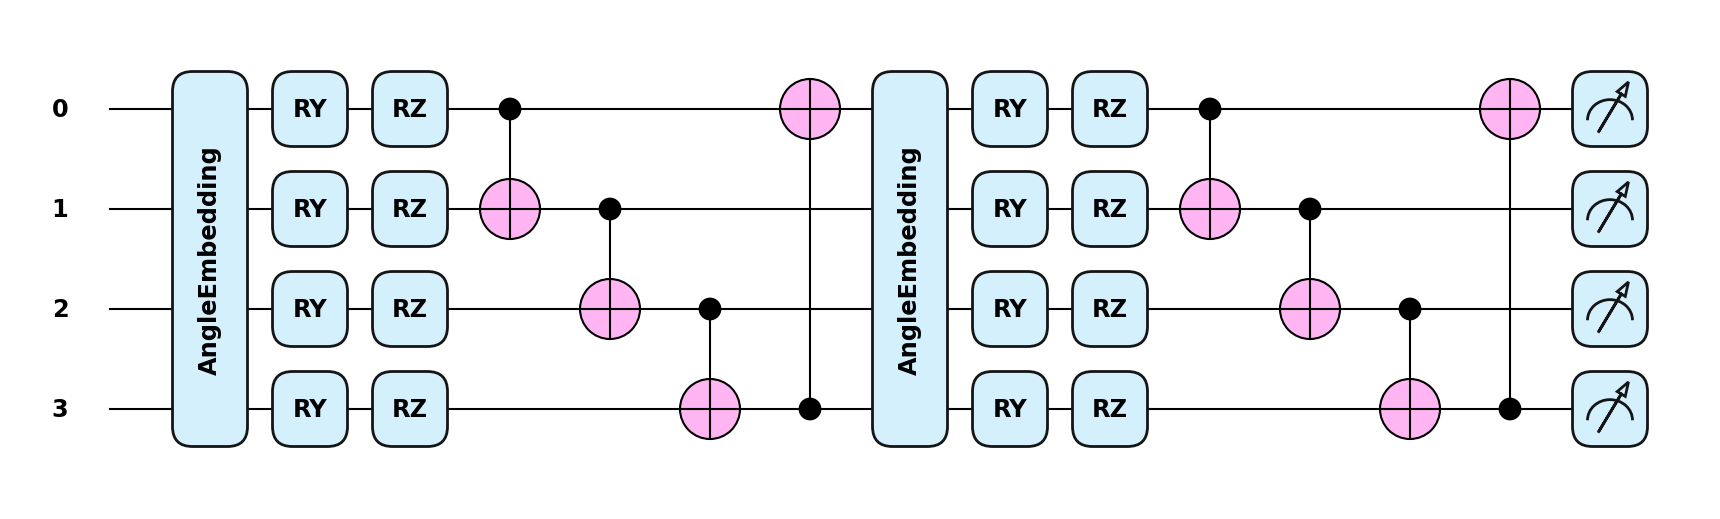

In [ ]:
# %%writefile quantum_models.py
import pennylane as qml
from pennylane import numpy as pnp
from torch import nn
import torch
import matplotlib.pyplot as plt
device = "cpu"
class Reupload_Net(nn.Module):
    def __init__(self, n_qubits=4, action_size=2, n_layers=3, device="cpu"):
      super(Reupload_Net, self).__init__()
      self.device = device
      self.reupload = True
      self.n_layers = n_layers
      self.n_qubits = n_qubits
      self.action_size = action_size
      self.weight_shapes = {"weights": (self.n_layers, self.n_qubits, 2),
                           "w_in":  (self.n_layers,self.n_qubits),
                            "w_out": (2)}
      self.dev = qml.device("default.qubit", wires=self.n_qubits)
      def layer(W):
        for i in range(self.n_qubits):
            # Parameterized Layer
          qml.RY(W[i,0], wires=i)
          qml.RZ(W[i,1], wires=i)
        for i in range(self.n_qubits):
          # Entangling
          qml.CNOT(wires=[i%self.n_qubits,(i+1)%self.n_qubits])
      @qml.qnode(self.dev, interface='torch', diff_method="backprop")
      def circuit(inputs,weights, w_in, w_out):
          # W: Layer Variable Parameters, s: State Variable
          for i in range(self.n_layers):
            # Weighted Input Encoding
            qml.AngleEmbedding(torch.atan(torch.multiply(inputs,w_in[i])), wires=range(self.n_qubits), rotation="X")
            layer(weights[i])
          return [qml.expval(qml.PauliZ(0)@qml.PauliZ(1) ),
                  qml.expval(qml.PauliZ(2)@qml.PauliZ(3) )]
      self.circuit = circuit
      self.qvc = qml.qnn.TorchLayer(circuit, self.weight_shapes,
                                    init_method={"weights":nn.init.uniform_, "w_in": nn.init.ones_, "w_out": nn.init.ones_})
      nn.init.uniform_(self.qvc.weights, 0,np.pi)

    def forward(self, x):
      out =  (self.qvc(x)+1)/2
      return torch.mul(out, self.qvc.w_out)

    def save_visual(self,path):
        self.fig.savefig(path)

    def print_circuit(self):
        self.drawer = qml.draw(self.circuit, show_all_wires=True)(
                                        torch.ones(self.n_qubits), self.qvc.weights,self.qvc.w_in, self.qvc.w_out)
        return self.drawer
    def print_circuit_mpl(self):
        qml.drawer.use_style("pennylane")
        self.drawer = qml.draw_mpl(self.circuit,
                                   fontsize="xx-large",
                                   orientation="portrait")(torch.ones(self.n_qubits), self.qvc.weights,self.qvc.w_in, self.qvc.w_out)
        return self.drawer
c = Reupload_Net(n_qubits=4,n_layers=2).to(device)
print(c.print_circuit_mpl())
# 'black_white', 'black_white_dark', 'sketch', 'pennylane', 'pennylane_sketch', 'sketch_dark', 'solarized_light', 'solarized_dark', 'default

In [ ]:
import re
# %%writefile DQN.py
from copy import copy
import gym
import matplotlib.pyplot as plt
from torch.optim import *
from collections import deque
import random
import numpy as np
import os
import time
import datetime
from pathlib import Path
import wandb
import math
import pprint  as pp

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

from collections import namedtuple,deque
import random
import numpy as np
import pandas as pd
import torch


class DQN(object):
    def __init__(self, model, config, name, use_wandb=False,  record_video=False, use_cuda =False) -> None:

        # Prep
        self.name = name
        self.use_wandb =use_wandb
        self.record_video = record_video
        self.use_cuda = use_cuda

        # HYPERPARAMETERS
        self.config = config
        self.env_name = self.config["env"]
        self.is_quantum = self.config["is_quantum"]
        self.lr = self.config["learning_rate"]
        self.gamma = self.config["gamma"]
        self.epsilon = self.config["epsilon"]
        self.epsilon_decay = self.config["epsilon_decay"]
        self.epsilon_min = self.config["epsilon_min"]
        self.batch = self.config["batch_size"]
        self.episodes = self.config["n_episodes"]
        self.buff = self.config["buffer_size"]
        self.update_target = self.config["update_target"]
        self.ddqn= self.config["is_DDQN"]
        self.use_per = self.config["use_PER"]
        self.is_ranking = self.config["is_ranking"]
        self.reupload= self.config["is_Reupload"]
        self.n_layers = self.config["n_layers"]
        self.loss_fn = self.config["loss"]
        self.per_alpha = self.config["PER_Alpha"]
        self.per_e = self.config["PER_e"]
        self.per_beta = self.config["PER_Beta"]
        self.per_beta_per= self.config["PER_Beta_increment"]
        self.pre_fill = self.config["pre_fill"]
        pp.pprint(config)

        # GYM environment
        if self.use_wandb:
          self.run = wandb.init(project="<PROJECT>",
                 entity="<USERNAME>",
                 name=self.name,
                 config=self.config,
                 monitor_gym=True,
                 save_code=True,
                 reinit=True)
          self.run.log_code(".")
          self.run.define_metric("Train Episode", hidden=True)
          self.run.define_metric("Test Episode", hidden=True)
          self.run.define_metric("Average Loss Per Episode","Train Episode")
          self.run.define_metric("Running Average Rewards (50)","Train Episode")
          self.run.define_metric("Q-values","Train Episode")
          self.run.define_metric("Average Q-values","Train Episode")
          self.run.define_metric("Total Train Rewards", "Train Episode")
          self.run.define_metric("Total Test Rewards", "Test Episode")
          self.run.define_metric("Epsilon","Train Episode")
          self.run.define_metric("Beta","Train Episode")
          self.run.define_metric("Importance Weights","Train Episode")
          self.run.define_metric("Average Importance Weights","Train Episode")

        self.env = gym.make(self.env_name)
        if self.env_name == "FrozenLake-v1":
          self.env = gym.make(self.env_name, is_slippery=False)
        if self.env_name == "Blackjack-v1":
          self.env = gym.make(self.env_name, sab=True, natural=True)

        if type(self.env.observation_space)==gym.spaces.box.Box:
          self.state_space = self.env.observation_space.shape[0]
        elif type(self.env.observation_space)==gym.spaces.discrete.Discrete:
          self.state_space = self.env.observation_space.n
        else:
          self.state_space = len(self.env.observation_space)
        if type(self.env.action_space)==gym.spaces.discrete.Discrete:
          self.action_space = self.env.action_space.n
        # Q-network
        self.q_network = model(self.state_space, self.action_space, self.n_layers)
        self.q_network_test = model(self.state_space, self.action_space, self.n_layers)
        # Quantum Reupload prep
        if self.reupload:
          self.lr_in = self.config["learning_rate_in"]
          self.lr_out = self.config["learning_rate_out"]
          self.param_in = [self.q_network.qvc.w_in]
          self.param_weights = [self.q_network.qvc.weights]
          self.param_out = [self.q_network.qvc.w_out]
          self.opt_in =Adam(self.param_in, lr=self.lr_in)
          self.opt_var =Adam(self.param_weights,lr=self.lr)
          self.opt_out =Adam(self.param_out, lr=self.lr_out)
        else:
          self.opt = Adam(self.q_network.parameters(),lr=self.lr)

        # Target network
        self.target = model(self.state_space, self.action_space, self.n_layers)
        self.sync_weights()
        self.target.eval()

        # GPU setup
        self.device = torch.device("cuda" if self.use_cuda else "cpu")
        if self.use_cuda:
            print("GPU being used:", torch.cuda.get_device_name(0))
            self.q_network.cuda(self.device)
            self.target.cuda(self.device)

        # DQN setup
        if self.use_per:
          self.memory = PER_Memory(self.state_space, 1, self.buff, self.per_alpha, self.per_beta, self.per_beta_per, self.per_e, self.is_ranking)
          self.per_beta_cur = self.memory.beta
        else:
          self.memory = ER_Memory(self.state_space, 1, self.buff)
          self.per_beta_cur = 0

        if self.use_wandb:
          self.run.watch(self.q_network, log="all",log_freq=1,
            criterion=self.loss_fn, log_graph=True)
          if self.is_quantum:
            self.run.log({"Circuit Ansatz": wandb.Image(self.q_network.print_circuit_mpl()[0])})

        self.step = 0
        self.current_episode = 0
        # stat tracking
        self.rewards = []
        self.avg_rewards = []
        self.losses = []
        self.q_values = []

        self.test_rewards = []
        self.test_avg_rewards = []
        self.test_q_values = []

        self.name = name
        self.path = "{}_logs".format(self.name)
        self.save_path = "{}/{}_ep_{}.pt".format(self.path,self.name,self.current_episode+1)
        os.makedirs(self.path, exist_ok=True)

    def preprocess_state(self,x):
        x = np.stack(x)

        if type(x[0]) != np.ndarray:
          x = np.eye(self.env.observation_space.n)[x]
        state = torch.tensor(x,dtype=torch.float32).to(self.device)
        return state

    def sync_weights(self):
        self.target.load_state_dict(self.q_network.state_dict())

    def sync_weights_test(self):
        self.q_network_test.load_state_dict(self.q_network.state_dict())

    def opt_zero_grad(self):
        if self.reupload:
            self.opt_in.zero_grad()
            self.opt_var.zero_grad()
            self.opt_out.zero_grad()
        else:
            self.opt.zero_grad()

    def opt_step(self):
        if self.reupload:
            self.opt_in.step()
            self.opt_var.step()
            self.opt_out.step()
        else:
            self.opt.step()

    def remember(self, state, action, reward, next_state, done):
        self.memory.remember(state, action, reward, next_state, done)

    def get_action(self, obs, is_train=True):
        if np.random.random() <= self.epsilon and is_train:
          action = self.env.action_space.sample()
        else:
          self.q_network.eval()
          obs = self.preprocess_state([obs])
          action = self.q_network(obs).argmax().item()
        return action


    def learn(self):
        epochs = 1
        for e in range(epochs):
          minibatch = self.memory.sample(min(len(self.memory), self.batch))
          states = self.preprocess_state(minibatch["states"])
          actions = torch.tensor(minibatch["actions"], dtype=torch.long).to(self.device)
          rewards = torch.tensor(minibatch["rewards"], dtype=torch.float32).to(self.device)
          next_states = self.preprocess_state(minibatch["next_states"])
          dones = torch.tensor(minibatch["dones"], dtype=torch.float32).unsqueeze(1).to(self.device)
          Q = self.q_network.forward(states).gather(1, actions)# Q(s, a, wq)
          # DDQN
          if self.ddqn:
            with torch.no_grad():
              A_best = self.q_network(next_states).max(1, keepdim=True)[1] #
              Q_next = self.target(next_states).gather(1, A_best) # max _a Q(ns, argmax_a(Q(ns, a, wq)) , wt)
              y = rewards + self.gamma *(1-dones) * Q_next
          # DQN
          else:
            with torch.no_grad():
              Q_next = self.target(next_states).max(1)[0].unsqueeze(1) # max _a Q(ns, a, wt)
              y = rewards + self.gamma *(1-dones) * Q_next # bellman
          self.opt_zero_grad()
          Qs = Q
          ys = y
          weights = torch.ones_like(Q)
          if self.use_per:
            # PER
            self.memory.alpha = self.per_alpha
            idx = minibatch["indexes"]
            td_error = torch.absolute(y-Q).squeeze(1).cpu().data.numpy()
            self.memory.update_priorities(idx, td_error)


            weights = torch.FloatTensor(minibatch["weights"]).unsqueeze(1).to(self.device).detach()
            delta_w= torch.multiply(torch.absolute(y-Q).squeeze(1),  weights)
            loss = torch.mean(delta_w.pow(2))
          else:
            loss = self.loss_fn(Qs, ys.detach())
          loss_ = self.loss_fn(Q, y.detach()).detach()
          loss.backward()
          self.opt_step()
          # print("epoch {}, loss {}".format(e, float(loss)))
        return float(loss_), Q.detach().numpy().flatten(), weights.numpy().flatten()

    def load(self, path):
        self.q_network.load_state_dict(torch.load(path))
        self.sync_weights()

    def pre_train(self):
        print("Filling Memory...")
        while len(self.memory)< self.buff:

          s1 = self.env.reset()

          done = False
          while not done:
              action = self.get_action(s1, is_train=False)
              s2, reward, done, _ = self.env.step(action)
              self.remember(s1,action,reward,s2,done)
              s1 = s2
              if done:
                  break
        print("Memory filled!")

    def train(self, episodes=None):
        if self.pre_fill:
          self.pre_train()
        if self.record_video:
          self.env = gym.wrappers.RecordVideo(gym.make(self.env_name), f"train_videos",  episode_trigger = lambda x: x % 20 == 0)
        if episodes == None:
          episodes = self.episodes
        start_episode = self.current_episode
        beta_update = (1-self.per_beta)/episodes
        episodes += start_episode
        for t in range(start_episode, episodes):
          start_time = time.time()
          s1 = self.env.reset()
          steps = 0
          total_reward = 0
          total_loss = []
          total_q = []
          total_w = []
          done = False
          while not done:
              action = self.get_action(s1, is_train=True)
              s2, reward, done, _ = self.env.step(action)
              self.epsilon = max(self.epsilon*self.epsilon_decay, self.epsilon_min)

              self.remember(s1,action,reward,s2,done)
              total_reward+=reward
              s1 = s2
              loss, q, iw = self.learn()
              if loss != None:
                total_loss.append(loss)
                for w in iw:
                  total_w.append(w)
                for j in q:
                  total_q.append(j)
              steps+=1
              if done:
                  episode_time = time.time() - start_time
                  # Store Trackable Stats
                  self.rewards.append(total_reward)
                  avg = np.mean(self.rewards[-50:])
                  self.avg_rewards.append(avg)
                  if self.use_per:
                    self.per_beta_cur = min(self.per_beta_cur +beta_update,1)
                    self.memory.beta = self.per_beta_cur
                  print("\rTRAIN: Episode {c_ep}/{n_ep} [{t} sec.]|| 50 Running Avg {a}, Episode Reward {tr}, Loss {l}, Q {q}, eps {eps}, beta {beta_cur}".format(
                        c_ep=self.current_episode+1,
                        n_ep=episodes,
                        t= np.round(episode_time, 3),
                        a=np.round(avg, 3),
                        tr=np.round(total_reward, 3),
                        l=np.round(np.mean(total_loss), 3),
                        q=np.round(np.mean(total_q),3),
                        eps=np.round(self.epsilon, 3),
                        beta_cur=np.round(self.per_beta_cur, 3)),flush=True, end="")
                  self.save_path = "{}/{}_ep_{}.pt".format(self.path,self.name,self.current_episode+1)
                  # self.memory.save("{}/{}_memory.npy".format(self.path,self.name))
                  torch.save(self.q_network.state_dict(), self.save_path)
                  if self.use_wandb:
                    self.run.log({"Total Train Rewards":total_reward,
                        "Average Loss Per Episode": np.mean(total_loss),
                        "Running Average Rewards (50)": avg,
                        "Q-values": wandb.Histogram(total_q),
                        "Average Q-values": np.mean(total_q),
                        "Beta": self.per_beta_cur,
                        "Epsilon": self.epsilon,
                        "Importance Weights": wandb.Histogram(total_w),
                        "Average Importance Weights": np.mean(total_w),
                        "Train Episode": t})
                    self.run.save("{}/*pt".format(self.path))


                  # if self.current_episode % self.update_target == 0:
                  #   self.sync_weights()
                  self.current_episode+=1
                  break
              self.step+=1
              if self.step % self.update_target == 0:
                self.sync_weights()

        print("Total Average Training Reward: ", np.mean(np.asarray(self.rewards)))
        if self.use_wandb:
          self.run.log({"Total Average Training Reward": np.mean(np.asarray(self.rewards))})

    def test(self,episodes=None):
        self.test_rewards = []
        self.test_avg_rewards = []
        self.test_q_values = []
        self.sync_weights_test()
        if episodes == None:
          episodes = self.episodes
        for t in range(episodes):
          start_time = time.time()
          s1 = self.env.reset()
          steps = 1
          total_reward = 0
          done = False
          while not done:
              action = self.get_action(s1, is_train=False)
              s2, reward, done, _ = self.env.step(action)
              total_reward+=reward
              if done:
                  episode_time = time.time() - start_time
                  # Store Trackable Stats
                  self.test_rewards.append(total_reward),
                  avg = np.mean(self.test_rewards[-50:])
                  self.test_avg_rewards.append(avg)
                  print("\rTEST: Episode {c_ep}/{n_ep} [{t} sec.]|| 50 Running Avg {a}, Episode Reward {tr}, eps {eps}".format(
                        c_ep=t+1,
                        n_ep=episodes,
                        t= np.round(episode_time, 3),
                        a=np.round(avg, 3),
                        tr=np.round(total_reward, 3),
                        eps=np.round(self.epsilon, 3)
                    ),flush=True, end="")
                  if self.use_wandb:
                    self.run.log({"Total Test Rewards": self.test_rewards[t], "Test Episode": t})
                  break
              s1 = s2
              steps+=1
        if self.use_wandb:
          self.run.log({"Total Average Test Reward": np.mean(np.asarray(self.test_rewards))})

In [ ]:
config = {
  "model":"C-DQN-Per-Rank",
  "env": "CartPole-v1",
  "is_quantum": False,
  "learning_rate": 0.001,
  "learning_rate_in": .01,
  "learning_rate_out": .1,
  "n_episodes": 200,
  "batch_size": 16,
  "gamma": .95,
  "epsilon": 1.0,
  "epsilon_decay": 0.995,
  "epsilon_min": .01,
  "buffer_size": 10000,
  "update_target": 10,
  "is_DDQN": False,
  "use_PER": False,
  "is_ranking": False,
  "PER_Alpha": .6,
  "PER_e": 1e-5,
  "PER_Beta": .4,
  "PER_Beta_increment": .01,
  "is_Reupload":False,
  "n_layers":3,
  "loss": torch.nn.MSELoss(),
  "pre_fill": False
}
config["use_PER"] = True
# config["is_DDQN"]= True
config["is_ranking"] = True

for i in range(0,10):
  torch.manual_seed(i)
  random.seed(i)
  torch.manual_seed(i)
  np.random.seed(i)
  config["seed"] = i
  agent_dqn = DQN(Dense_Net, config, "{}-{}".format(config["model"], i), use_wandb=True,
                    use_cuda=False,record_video=True)
  agent_dqn.env.reset(seed=i)
  agent_dqn.env.action_space.seed(i)
  agent_dqn.env.observation_space.seed(i)
  agent_dqn.train()
  agent_dqn.test()
  agent_dqn.run.finish()

In [ ]:
config = {
  "model":"DQN-ER",
  "env": "CartPole-v1",
  "is_quantum": False,
  "learning_rate": 0.001,
  "learning_rate_in": .01,
  "learning_rate_out": .1,
  "n_episodes": 200,
  "batch_size": 64,
  "gamma": .95,
  "epsilon": 1.0,
  "epsilon_decay": 0.99,
  "epsilon_min": .01,
  "buffer_size": 10000,
  "update_target": 1,
  "is_DDQN": False,
  "use_PER": True,
  "is_ranking": False,
  "PER_Alpha": .5,
  "PER_e": 1e-5,
  "PER_Beta": .4,
  "PER_Beta_increment": .0001,
  "is_Reupload":False,
  "n_layers":3,
  "loss": torch.nn.MSELoss(),
  "pre_fill": False
}
for i in range(9,10):
  torch.manual_seed(i)
  random.seed(i)
  torch.manual_seed(i)
  np.random.seed(i)
  config["seed"] = i
  agent_dqn = DQN(Dense_Net, config, "{}-{}".format(config["model"], i), use_wandb=False,
                    use_cuda=False,record_video=False)
  agent_dqn.env.reset(seed=i)
  agent_dqn.env.action_space.seed(i)
  agent_dqn.env.observation_space.seed(i)
  agent_dqn.train()
  agent_dqn.test()
  # agent_dqn.run.finish()